In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install MTCNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 14.8 MB/s 


In [4]:
from mtcnn import MTCNN
import cv2
import os, glob
import numpy as np
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm_notebook
import shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import keras

In [5]:
pwd


'/content'

UnRara or UnZip in Drive to work on that DataSet

In [6]:
!pip install unrar
!unrar x "/content/drive/MyDrive/Datasets/SFEW2.0.rar"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Datasets/SFEW2.0.rar

Creating    SFEW2.0                                                   OK
Creating    SFEW2.0/Test_DataSet_As_Per_Emotion_SFEW2                 OK
Creating    SFEW2.0/Test_DataSet_As_Per_Emotion_SFEW2/Final_SFEW_2_Test  OK
Extracting  SFEW2.0/Test_DataSet_As_Per_Emotion_SFEW2/Final_SFEW_2_Test/AfterTheSunSet_002350240_00000068.png       0%  OK 
Extracting  SFEW2.0/Test_DataSet_As_Per_Emotion_SFEW2/Final_SFEW_2_Test/AfterTheSunSet_004119160_00000011.png       0%  OK 
Extracting  SFEW2.0/Test_DataSet_As_Per_Emotion_SFEW2/Final_SFEW_2_Test/AfterTheSunSet_004119160_00000036.png       0%  OK 
Extracting  SFEW2.0/Test_DataSet_As_Per_Emotion_SFEW2/Final_SFEW_2_Test/AfterTheSunSet_004119160_00000042.png       0%  OK 
Extracting  SFEW2

In [8]:
def crop_image(img, detector): 
    data=detector.detect_faces(img)
    biggest=0
    if data !=[]:
        for faces in data:
            box=faces['box']            
            area = box[3]  * box[2]
            if area>biggest:
                biggest=area
                bbox=box 
        bbox[0]= 0 if bbox[0]<0 else bbox[0]
        bbox[1]= 0 if bbox[1]<0 else bbox[1]
        img=img[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]]        
        return (True, img) 
    else:
        return (False, None)

def align_crop_resize(src_list, dest_list, detector, height=None, width= None): 
    success_count=0
    for i,f in tqdm_notebook(enumerate(src_list)):
        dest_dir = os.path.dirname(dest_list[i])
        if not os.path.isdir(dest_dir):
            os.makedirs(dest_dir)
      
        if os.path.isfile(src_list[i]):
            try:
                img=cv2.imread(src_list[i]) 
                shape=img.shape
                  
                cstatus, img=crop_image(img, detector)
                if cstatus:
                    if height != None and width !=None:
                        img=cv2.resize(img, (height, width)) 

                    cv2.imwrite(dest_list[i], img) 
                    success_count +=1
            except:
                print('file ', src_list[i], ' is a bad image file')
    return success_count

detector = MTCNN()
src_list = glob.glob("/content/SFEW2/Train_DataSet_As_Per_Emotion_SFEW2/*/*")
dest_list = [src_list[i].replace("SFEW2", "Cropped_SFEW2") for i in range(len(src_list))] 

align_crop_resize(src_list, dest_list, detector, height=224, width= 224)

0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


513

In [10]:
!cp -r Cropped_SFEW2 "/content/drive/MyDrive/Datasets"

In [12]:
os.listdir("/content/SFEW2/Train_DataSet_As_Per_Emotion_SFEW2/")

['Fear',
 'Happy',
 'Surprise',
 'Disgust',
 '.ipynb_checkpoints',
 'Sad',
 'Angry',
 'Neutral']

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [14]:
base_model = keras.applications.MobileNetV3Large(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
    classes=7,
    
) 

base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs, outputs)

12683000/12683000 [==============================] - 0s 0us/step


In [15]:
path="/content/Cropped_SFEW2/Train_DataSet_As_Per_Emotion_Cropped_SFEW2"

# dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical")
train_dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical", validation_split=0.3, subset="training", seed=42)
valid_dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical", validation_split=0.3, subset="validation", seed=42)



Found 513 files belonging to 7 classes.
Using 360 files for training.
Found 513 files belonging to 7 classes.
Using 153 files for validation.


In [28]:
for i in os.listdir("/content/Cropped_SFEW2/Train_DataSet_As_Per_Emotion_Cropped_SFEW2"):
  print(i,len(os.listdir("/content/Cropped_SFEW2/Train_DataSet_As_Per_Emotion_Cropped_SFEW2/"+i)))

Fear 49
Happy 112
Surprise 49
Disgust 33
Sad 96
Angry 91
Neutral 83


In [27]:
train_dataset.class_names

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [29]:
class_weight={0:1.2,1:3.5,2:2.5,3:1,4:1.3,5:1.22,6:2.5}

In [30]:

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              
              metrics=["accuracy"])
# model.fit(dataset, epochs=20, validation_split=0.2)
history = model.fit(train_dataset, epochs=50,class_weight=class_weight, validation_data=valid_dataset)

Epoch 1/50
12/12 [==============================] - 15s 987ms/step - loss: 3.2886 - accuracy: 0.1250 - val_loss: 1.9416 - val_accuracy: 0.2092
Epoch 2/50
12/12 [==============================] - 10s 796ms/step - loss: 2.9463 - accuracy: 0.2611 - val_loss: 1.9359 - val_accuracy: 0.2288
Epoch 3/50
12/12 [==============================] - 10s 828ms/step - loss: 2.7620 - accuracy: 0.2972 - val_loss: 1.9192 - val_accuracy: 0.2484
Epoch 4/50
12/12 [==============================] - 13s 991ms/step - loss: 2.5907 - accuracy: 0.4056 - val_loss: 1.8396 - val_accuracy: 0.2876
Epoch 5/50
12/12 [==============================] - 10s 793ms/step - loss: 2.4503 - accuracy: 0.4583 - val_loss: 1.8445 - val_accuracy: 0.2810
Epoch 6/50
12/12 [==============================] - 10s 803ms/step - loss: 2.3220 - accuracy: 0.4833 - val_loss: 1.7927 - val_accuracy: 0.3007
Epoch 7/50
12/12 [==============================] - 11s 932ms/step - loss: 2.2281 - accuracy: 0.5361 - val_loss: 1.7675 - val_accuracy: 0.3399

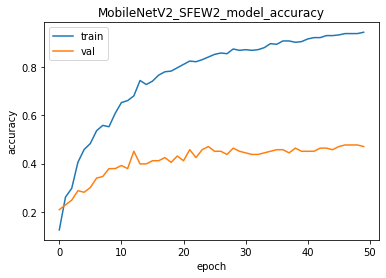

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNetV2_SFEW2_model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('MobileNetV2_SFEW2_model_accuracy.png')
!cp MobileNetV2_SFEW2_model_accuracy.png "/content/drive/MyDrive/Datasets"
plt.show()


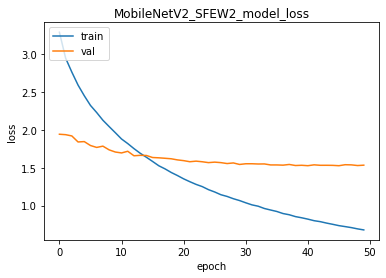

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNetV2_SFEW2_model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('MobileNetV2_SFEW2_model_loss.png')
!cp MobileNetV2_SFEW2_model_loss.png "/content/drive/MyDrive/Datasets"
plt.show()

In [33]:
print("Training Accuracy ",max(history.history['accuracy']))
print("Testing Accuracy",max(history.history['val_accuracy']))


Training Accuracy  0.9444444179534912
Testing Accuracy 0.4771241843700409


In [35]:
model.save("mobilenetv2_SFEW2")
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("mobilenetv2_SFEW2") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model in the .tflite .
with open('mobilenetv2_SFEW2.tflite', 'wb') as f:
  f.write(tflite_model)

# copy the .tflite to Drive
!cp mobilenetv2_SFEW2.tflite "/content/drive/MyDrive/Datasets"

EfficientNetB7 using SFEW2

In [36]:
base_model = keras.applications.efficientnet.EfficientNetB7(
    weights = 'imagenet',  # Load weights pre-trained on ImageNet.
    input_shape = (224, 224, 3),
    include_top = False,
    classifier_activation = "softmax",
    classes = 7
) 

base_model.trainable = False

# inputs = keras.Input(shape=(224, 224, 3))
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs, outputs)

258076736/258076736 [==============================] - 2s 0us/step


In [37]:
path="/content/Cropped_SFEW2/Train_DataSet_As_Per_Emotion_Cropped_SFEW2"

# dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical")
train_dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical", validation_split=0.3, subset="training", seed=42)
valid_dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical", validation_split=0.3, subset="validation", seed=42)

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# model.fit(dataset, epochs=20, validation_split=0.2)
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)


Found 513 files belonging to 7 classes.
Using 360 files for training.
Found 513 files belonging to 7 classes.
Using 153 files for validation.
Epoch 1/50
12/12 [==============================] - 180s 14s/step - loss: 1.8748 - accuracy: 0.2306 - val_loss: 1.7656 - val_accuracy: 0.3072
Epoch 2/50
12/12 [==============================] - 164s 14s/step - loss: 1.6171 - accuracy: 0.4111 - val_loss: 1.6714 - val_accuracy: 0.3399
Epoch 3/50
12/12 [==============================] - 164s 14s/step - loss: 1.4775 - accuracy: 0.5222 - val_loss: 1.5740 - val_accuracy: 0.4052
Epoch 4/50
12/12 [==============================] - 161s 14s/step - loss: 1.3677 - accuracy: 0.5361 - val_loss: 1.5203 - val_accuracy: 0.4118
Epoch 5/50
12/12 [==============================] - 166s 14s/step - loss: 1.2858 - accuracy: 0.5833 - val_loss: 1.5065 - val_accuracy: 0.4314
Epoch 6/50
12/12 [==============================] - 166s 14s/step - loss: 1.2068 - accuracy: 0.6417 - val_loss: 1.4620 - val_accuracy: 0.4510
Epoch 

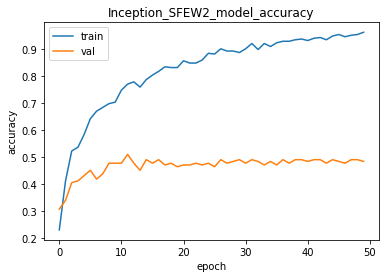

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Inception_SFEW2_model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Inception_SFEW2_model_accuracy.png')
!cp Inception_SFEW2_model_accuracy.png "/content/drive/MyDrive/Datasets"
plt.show()


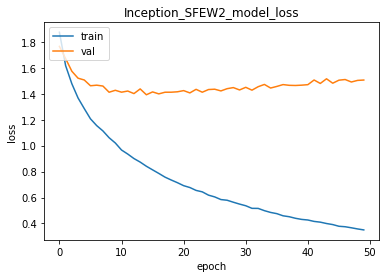

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Inception_SFEW2_model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Inception_SFEW2_model_loss.png')
!cp Inception_SFEW2_model_loss.png "/content/drive/MyDrive/Datasets"
plt.show()

In [40]:
print("Training Accuracy ",max(history.history['accuracy']))
print("Testing Accuracy",max(history.history['val_accuracy']))


Training Accuracy  0.9611111283302307
Testing Accuracy 0.5098039507865906


In [41]:
model.save("InceptionNet_SFEW2")
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("InceptionNet_SFEW2") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model in the .tflite .
with open('InceptionNet_SFEW2.tflite', 'wb') as f:
  f.write(tflite_model)

# copy the .tflite to Drive
!cp InceptionNet_SFEW2.tflite "/content/drive/MyDrive/Datasets"

Inception using SFEW2

In [10]:
base_model = keras.applications.InceptionV3(
    weights = 'imagenet',  # Load weights pre-trained on ImageNet.
    input_shape = (224, 224, 3),
    include_top = False,
    classifier_activation = "softmax",
    classes = 7
) 

base_model.trainable = False

# inputs = keras.Input(shape=(224, 224, 3))
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [11]:
path="/content/drive/MyDrive/Datasets/Cropped_SFEW2/Train_DataSet_As_Per_Emotion_Cropped_SFEW2"

# dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical")
train_dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical", validation_split=0.3, subset="training", seed=42)
valid_dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical", validation_split=0.3, subset="validation", seed=42)

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# model.fit(dataset, epochs=20, validation_split=0.2)
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)


Found 513 files belonging to 7 classes.
Using 360 files for training.
Found 513 files belonging to 7 classes.
Using 153 files for validation.
Epoch 1/50
12/12 [==============================] - 159s 8s/step - loss: 14.3586 - accuracy: 0.1750 - val_loss: 11.7038 - val_accuracy: 0.1373
Epoch 2/50
12/12 [==============================] - 62s 5s/step - loss: 9.9040 - accuracy: 0.2028 - val_loss: 7.8059 - val_accuracy: 0.1765
Epoch 3/50
12/12 [==============================] - 57s 5s/step - loss: 5.8657 - accuracy: 0.2417 - val_loss: 5.4673 - val_accuracy: 0.2092
Epoch 4/50
12/12 [==============================] - 58s 5s/step - loss: 4.2771 - accuracy: 0.2667 - val_loss: 4.8217 - val_accuracy: 0.2418
Epoch 5/50
12/12 [==============================] - 58s 5s/step - loss: 3.4804 - accuracy: 0.2972 - val_loss: 4.4341 - val_accuracy: 0.2222
Epoch 6/50
12/12 [==============================] - 61s 5s/step - loss: 2.9623 - accuracy: 0.3722 - val_loss: 4.6511 - val_accuracy: 0.2353
Epoch 7/50
12/1

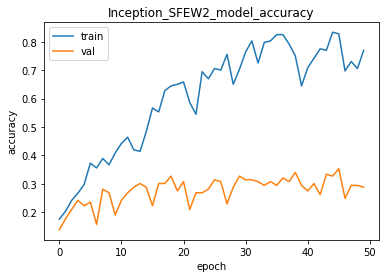

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Inception_SFEW2_model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Inception_SFEW2_model_accuracy.png')
!cp Inception_SFEW2_model_accuracy.png "/content/drive/MyDrive/Datasets"
plt.show()


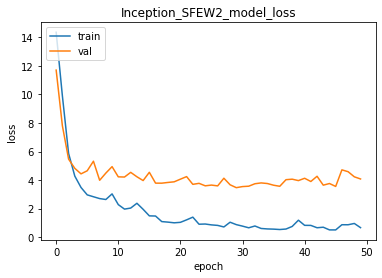

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Inception_SFEW2_model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Inception_SFEW2_model_loss.png')
!cp Inception_SFEW2_model_loss.png "/content/drive/MyDrive/Datasets"
plt.show()

In [14]:
print("Training Accuracy ",max(history.history['accuracy']))
print("Testing Accuracy",max(history.history['val_accuracy']))


Training Accuracy  0.8333333134651184
Testing Accuracy 0.3529411852359772


In [15]:
model.save("InceptionNet_SFEW2")
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("InceptionNet_SFEW2") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model in the .tflite .
with open('InceptionNet_SFEW2.tflite', 'wb') as f:
  f.write(tflite_model)

# copy the .tflite to Drive
!cp InceptionNet_SFEW2.tflite "/content/drive/MyDrive/Datasets"